In [1]:
import numpy as np
import os
import sys
parent_path=os.path.dirname(os.getcwd())
sys.path.append(parent_path+'/src')


from reaction_data import get_graph_data

rsmi_list = ['CCOC(C)=O.COCCOc1ccc(CCCN)c(Oc2ncc(C(F)(F)F)cc2Cl)c1.Cl.O=S(=O)(Cl)c1ccccc1Cl.c1ccncc1>>COCCOc1ccc(CCCNS(=O)(=O)c2ccccc2Cl)c(Oc2ncc(C(F)(F)F)cc2Cl)c1']
rmol_max_cnt = np.max([smi.split(">>")[0].count(".") + 1 for smi in rsmi_list])
pmol_max_cnt = np.max([smi.split(">>")[1].count(".") + 1 for smi in rsmi_list])

a,b,c=get_graph_data(rsmi_list,rmol_max_cnt, pmol_max_cnt)

c:\Users\chung\anaconda3\envs\syncat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- generating graph data for None
--- n_reactions: 1, reactant_max_cnt: 5, product_max_cnt: 1


In [2]:
from data import GraphDataset

d=GraphDataset(save_path=None,rmol = a, pmol= b, reaction= c)

In [4]:
from torch.utils.data import DataLoader
from utils import collate_reaction_graphs
loader = DataLoader(
    dataset=d,
    batch_size=int(np.min([32,len(d)])),
    shuffle=False,
    collate_fn=collate_reaction_graphs,
)

In [6]:
node_dim = d.rmol_node_attr[0].shape[1]
edge_dim = d.rmol_edge_attr[0].shape[1]
print(node_dim)
print(edge_dim)

155
9


In [13]:
from rdkit.Chem import AllChem, Draw
def visual_reaction(rsmi):
    reaction=AllChem.ReactionFromSmarts(rsmi, useSmiles=True)
    return display(Draw.ReactionToImage(reaction))


In [19]:
df_test_43=df_test[df_test['rxn_class']==43]
df_test_43=df_test_43.reset_index()

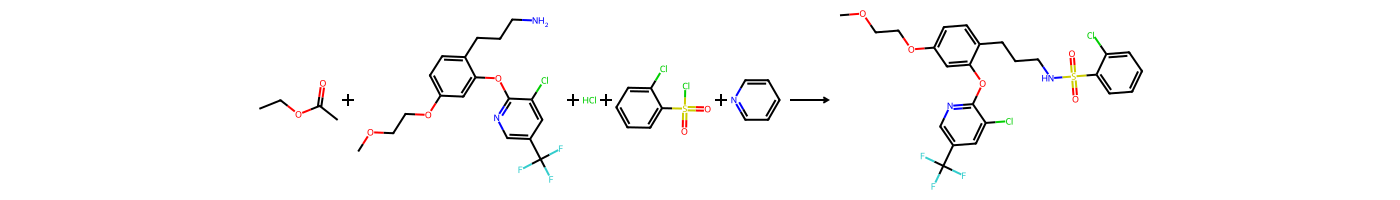

In [21]:
visual_reaction(df_test_43.loc[0,'rxn'])

'CCOC(C)=O.COCCOc1ccc(CCCN)c(Oc2ncc(C(F)(F)F)cc2Cl)c1.Cl.O=S(=O)(Cl)c1ccccc1Cl.c1ccncc1>>COCCOc1ccc(CCCNS(=O)(=O)c2ccccc2Cl)c(Oc2ncc(C(F)(F)F)cc2Cl)c1'